In [1]:
 from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/AIcup"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/我的 MacBook Pro/AIcup


In [2]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU加速已啟用")
else:
    print("使用CPU運行")

GPU加速已啟用


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 設定路徑
TRAIN_ROOT = '39_Training_Dataset'
TEST_ROOT = '39_Test_Dataset'
TRAIN_INFO = os.path.join(TRAIN_ROOT, 'train_info.csv')
TEST_INFO = os.path.join(TEST_ROOT, 'test_info.csv')
TRAIN_DATA_DIR = os.path.join(TRAIN_ROOT, 'train_data')
TEST_DATA_DIR = os.path.join(TEST_ROOT, 'test_data')
SAMPLE_SUB = os.path.join(TEST_ROOT, 'sample_submission.csv')

# 設定參數
MAX_SEQUENCE_LENGTH = 2000  # 最大序列長度
FEATURES = 6  # 6軸感測器數據
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

In [5]:
class FocalLoss(tf.keras.losses.Loss):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1.0, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
        ce_loss = -y_true * tf.math.log(y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        focal_loss = alpha_t * tf.pow(1 - p_t, self.gamma) * ce_loss
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))

def load_sensor_data(file_path):
    """載入感測器數據"""
    try:
        data = []
        with open(file_path, 'r') as f:
            for line_num, line in enumerate(f.readlines()):
                if line.strip() == '' or line_num == 0:
                    continue
                parts = line.strip().split()
                if len(parts) >= 6:
                    row = [float(parts[i]) for i in range(6)]
                    data.append(row)
        return np.array(data)
    except:
        return None

def preprocess_sequence(data, max_length=MAX_SEQUENCE_LENGTH):
    """預處理時間序列數據"""
    if data is None or len(data) == 0:
        return np.zeros((max_length, FEATURES))

    # 標準化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 處理序列長度
    if len(data_scaled) > max_length:
        # 如果太長，等間隔採樣
        indices = np.linspace(0, len(data_scaled)-1, max_length, dtype=int)
        data_scaled = data_scaled[indices]
    elif len(data_scaled) < max_length:
        # 如果太短，零填充
        padding = np.zeros((max_length - len(data_scaled), FEATURES))
        data_scaled = np.vstack([data_scaled, padding])

    return data_scaled

def create_hybrid_model(max_length=MAX_SEQUENCE_LENGTH, n_features=FEATURES):
    """創建混合CNN-LSTM模型"""
    inputs = layers.Input(shape=(max_length, n_features))

    # 多尺度CNN特徵提取
    conv_outputs = []
    for kernel_size in [3, 5, 7]:
        conv = layers.Conv1D(64, kernel_size, padding='same', activation='relu')(inputs)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Dropout(0.3)(conv)
        conv = layers.MaxPooling1D(2)(conv)

        conv = layers.Conv1D(128, kernel_size, padding='same', activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Dropout(0.3)(conv)
        conv = layers.MaxPooling1D(2)(conv)

        conv_outputs.append(conv)

    # 合併多尺度特徵
    if len(conv_outputs) > 1:
        merged = layers.Concatenate()(conv_outputs)
    else:
        merged = conv_outputs[0]

    # 雙向LSTM層
    lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(merged)
    lstm = layers.Dropout(0.4)(lstm)
    lstm = layers.Bidirectional(layers.LSTM(64))(lstm)
    lstm = layers.Dropout(0.4)(lstm)

    # 全連接層
    dense = layers.Dense(256, activation='relu')(lstm)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.5)(dense)
    dense = layers.Dense(128, activation='relu')(dense)
    dense = layers.Dropout(0.3)(dense)

    # 多任務輸出
    gender_output = layers.Dense(1, activation='sigmoid', name='gender')(dense)
    hand_output = layers.Dense(1, activation='sigmoid', name='hand')(dense)
    years_output = layers.Dense(3, activation='softmax', name='years')(dense)
    level_output = layers.Dense(4, activation='softmax', name='level')(dense)

    model = Model(inputs=inputs, outputs=[gender_output, hand_output, years_output, level_output])
    return model

def prepare_data():
    """準備訓練數據"""
    print("載入訓練資訊...")
    train_info = pd.read_csv(TRAIN_INFO)

    X_data = []
    y_gender = []
    y_hand = []
    y_years = []
    y_level = []

    print("處理訓練數據...")
    for idx, row in train_info.iterrows():
        unique_id = row['unique_id']
        file_path = os.path.join(TRAIN_DATA_DIR, f"{unique_id}.txt")

        # 載入感測器數據
        sensor_data = load_sensor_data(file_path)
        if sensor_data is not None:
            processed_data = preprocess_sequence(sensor_data)
            X_data.append(processed_data)

            # 準備標籤
            y_gender.append(1 if row['gender'] == 'male' else 0)
            y_hand.append(1 if row['hold racket handed'] == 'right' else 0)
            y_years.append(row['play years'])
            y_level.append(row['level'] - 2)  # 轉換為0-3範圍

        if (idx + 1) % 100 == 0:
            print(f"已處理 {idx + 1}/{len(train_info)} 個檔案")

    # 轉換為numpy數組
    X_data = np.array(X_data)
    y_gender = np.array(y_gender)
    y_hand = np.array(y_hand)
    y_years = np.array(y_years)
    y_level = np.array(y_level)

    print(f"數據形狀: X={X_data.shape}, 性別={y_gender.shape}, 持拍手={y_hand.shape}")
    print(f"球齡={y_years.shape}, 等級={y_level.shape}")

    return X_data, y_gender, y_hand, y_years, y_level

def compute_class_weights(y_years, y_level):
    """計算類別權重"""
    years_weights = compute_class_weight('balanced', classes=np.unique(y_years), y=y_years)
    level_weights = compute_class_weight('balanced', classes=np.unique(y_level), y=y_level)

    years_weight_dict = {i: weight for i, weight in enumerate(years_weights)}
    level_weight_dict = {i: weight for i, weight in enumerate(level_weights)}

    return years_weight_dict, level_weight_dict

def train_model():
    """訓練模型"""
    # 準備數據
    X, y_gender, y_hand, y_years, y_level = prepare_data()

    # 分割數據
    X_train, X_val, y_gender_train, y_gender_val = train_test_split(
        X, y_gender, test_size=0.2, random_state=42, stratify=y_gender)

    _, _, y_hand_train, y_hand_val = train_test_split(
        X, y_hand, test_size=0.2, random_state=42, stratify=y_gender)

    _, _, y_years_train, y_years_val = train_test_split(
        X, y_years, test_size=0.2, random_state=42, stratify=y_gender)

    _, _, y_level_train, y_level_val = train_test_split(
        X, y_level, test_size=0.2, random_state=42, stratify=y_gender)

    # 轉換多分類標籤為one-hot編碼
    y_years_train_cat = tf.keras.utils.to_categorical(y_years_train, 3)
    y_years_val_cat = tf.keras.utils.to_categorical(y_years_val, 3)
    y_level_train_cat = tf.keras.utils.to_categorical(y_level_train, 4)
    y_level_val_cat = tf.keras.utils.to_categorical(y_level_val, 4)

    # 計算類別權重
    years_weights, level_weights = compute_class_weights(y_years_train, y_level_train)

    # 創建模型
    print("創建模型...")
    model = create_hybrid_model()

    # 編譯模型
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss={
            'gender': 'binary_crossentropy',
            'hand': 'binary_crossentropy',
            'years': FocalLoss(alpha=0.25, gamma=2.0),
            'level': FocalLoss(alpha=0.25, gamma=2.0)
        },
        loss_weights={
            'gender': 1.0,
            'hand': 1.0,
            'years': 2.0,  # 增加球齡任務權重
            'level': 2.0   # 增加等級任務權重
        },
        metrics={
            'gender': 'accuracy',
            'hand': 'accuracy',
            'years': 'accuracy',
            'level': 'accuracy'
        }
    )

    print(model.summary())

    # 回調函數
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)
    ]

    # 訓練模型
    print("開始訓練...")
    history = model.fit(
        X_train,
        {
            'gender': y_gender_train,
            'hand': y_hand_train,
            'years': y_years_train_cat,
            'level': y_level_train_cat
        },
        validation_data=(
            X_val,
            {
                'gender': y_gender_val,
                'hand': y_hand_val,
                'years': y_years_val_cat,
                'level': y_level_val_cat
            }
        ),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_val, y_gender_val, y_hand_val, y_years_val, y_level_val):
    """評估模型性能"""
    print("評估模型...")

    # 預測
    predictions = model.predict(X_val)

    # 轉換預測結果
    gender_pred = (predictions[0] > 0.5).astype(int).flatten()
    hand_pred = (predictions[1] > 0.5).astype(int).flatten()
    years_pred = np.argmax(predictions[2], axis=1)
    level_pred = np.argmax(predictions[3], axis=1)

    # 計算準確率
    print(f"性別準確率: {np.mean(gender_pred == y_gender_val):.4f}")
    print(f"持拍手準確率: {np.mean(hand_pred == y_hand_val):.4f}")
    print(f"球齡準確率: {np.mean(years_pred == y_years_val):.4f}")
    print(f"等級準確率: {np.mean(level_pred == y_level_val):.4f}")

    # 詳細分類報告
    print("\n球齡分類報告:")
    print(classification_report(y_years_val, years_pred))

    print("\n等級分類報告:")
    print(classification_report(y_level_val, level_pred))

def generate_predictions():
    """生成測試集預測"""
    print("載入測試資訊...")
    test_info = pd.read_csv(TEST_INFO)
    sample_sub = pd.read_csv(SAMPLE_SUB)

    # 準備測試數據
    X_test = []
    test_ids = []

    print("處理測試數據...")
    for idx, row in test_info.iterrows():
        unique_id = row['unique_id']
        file_path = os.path.join(TEST_DATA_DIR, f"{unique_id}.txt")

        sensor_data = load_sensor_data(file_path)
        if sensor_data is not None:
            processed_data = preprocess_sequence(sensor_data)
            X_test.append(processed_data)
            test_ids.append(unique_id)

        if (idx + 1) % 100 == 0:
            print(f"已處理 {idx + 1}/{len(test_info)} 個測試檔案")

    X_test = np.array(X_test)

    # 載入訓練好的模型
    print("載入模型進行預測...")
    # 這裡假設模型已經訓練並保存
    # model = tf.keras.models.load_model('best_model.h5')

    # 由於無法直接載入，這裡重新訓練
    model, _ = train_model()

    # 預測
    predictions = model.predict(X_test)

    # 處理預測結果
    result_df = sample_sub.copy()

    for i, unique_id in enumerate(test_ids):
        if unique_id in result_df['unique_id'].values:
            idx = result_df[result_df['unique_id'] == unique_id].index[0]

            # 性別預測
            result_df.loc[idx, 'gender'] = predictions[0][i][0]

            # 持拍手預測
            result_df.loc[idx, 'hold racket handed'] = predictions[1][i][0]

            # 球齡預測
            years_probs = predictions[2][i]
            result_df.loc[idx, 'play years_0'] = years_probs[0]
            result_df.loc[idx, 'play years_1'] = years_probs[1]
            result_df.loc[idx, 'play years_2'] = years_probs[2]

            # 等級預測
            level_probs = predictions[3][i]
            result_df.loc[idx, 'level_2'] = level_probs[0]
            result_df.loc[idx, 'level_3'] = level_probs[1]
            result_df.loc[idx, 'level_4'] = level_probs[2]
            result_df.loc[idx, 'level_5'] = level_probs[3]

    # 保存結果
    result_df.to_csv('submission.csv', index=False)
    print("預測結果已保存至 submission.csv")

    return result_df

def plot_training_history(history):
    """繪製訓練歷史"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 損失函數
    axes[0, 0].plot(history.history['loss'], label='訓練損失')
    axes[0, 0].plot(history.history['val_loss'], label='驗證損失')
    axes[0, 0].set_title('模型損失')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('損失')
    axes[0, 0].legend()

    # 性別準確率
    axes[0, 1].plot(history.history['gender_accuracy'], label='訓練準確率')
    axes[0, 1].plot(history.history['val_gender_accuracy'], label='驗證準確率')
    axes[0, 1].set_title('性別分類準確率')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('準確率')
    axes[0, 1].legend()

    # 球齡準確率
    axes[1, 0].plot(history.history['years_accuracy'], label='訓練準確率')
    axes[1, 0].plot(history.history['val_years_accuracy'], label='驗證準確率')
    axes[1, 0].set_title('球齡分類準確率')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('準確率')
    axes[1, 0].legend()

    # 等級準確率
    axes[1, 1].plot(history.history['level_accuracy'], label='訓練準確率')
    axes[1, 1].plot(history.history['val_level_accuracy'], label='驗證準確率')
    axes[1, 1].set_title('等級分類準確率')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('準確率')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

開始乒乓球揮拍資料分析...
GPU可用性: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
載入訓練資訊...
處理訓練數據...
已處理 100/1955 個檔案
已處理 200/1955 個檔案
已處理 300/1955 個檔案
已處理 400/1955 個檔案
已處理 500/1955 個檔案
已處理 600/1955 個檔案
已處理 700/1955 個檔案
已處理 800/1955 個檔案
已處理 900/1955 個檔案
已處理 1000/1955 個檔案
已處理 1100/1955 個檔案
已處理 1200/1955 個檔案
已處理 1300/1955 個檔案
已處理 1400/1955 個檔案
已處理 1500/1955 個檔案
已處理 1600/1955 個檔案
已處理 1700/1955 個檔案
已處理 1800/1955 個檔案
已處理 1900/1955 個檔案
數據形狀: X=(1955, 2000, 6), 性別=(1955,), 持拍手=(1955,)
球齡=(1955,), 等級=(1955,)
創建模型...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2000, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2000, 64)  │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 64)  │      1,984 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2000, 64)  │      2,752 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2000, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1000, 64)  │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1000, 64)  │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1000, 64)  │          0 │ dropout_4[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 128) │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 128) │     41,088 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1000, 128) │     57,472 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1000, 128) │          0 │ batch_normalizat

 Total params: 889,289 (3.39 MB)

 Trainable params: 887,625 (3.39 MB)

 Non-trainable params: 1,664 (6.50 KB)

None
開始訓練...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - gender_accuracy: 0.6966 - gender_loss: 0.6216 - hand_accuracy: 0.8451 - hand_loss: 0.3508 - level_accuracy: 0.3711 - level_loss: 0.3428 - loss: 2.3399 - years_accuracy: 0.3597 - years_loss: 0.3409 - val_gender_accuracy: 1.0000 - val_gender_loss: 0.4194 - val_hand_accuracy: 1.0000 - val_hand_loss: 0.4740 - val_level_accuracy: 0.6471 - val_level_loss: 0.1602 - val_loss: 1.4361 - val_years_accuracy: 0.5575 - val_years_loss: 0.1125 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - gender_accuracy: 0.9888 - gender_loss: 0.0646 - hand_accuracy: 0.9985 - hand_loss: 0.0431 - level_accuracy: 0.5353 - level_loss: 0.2179 - loss: 0.9747 - years_accuracy: 0.4912 - years_loss: 0.2156 - val_gender_accuracy: 1.0000 - val_gender_loss: 0.3003 - val_hand_accuracy: 1.0000 - val_hand_loss: 0.3824 - val_level_accuracy: 0.6317 - val_level_loss: 0.1462 - val_loss: 1.2038 - val_years_accuracy: 0.4962 - val_years_l

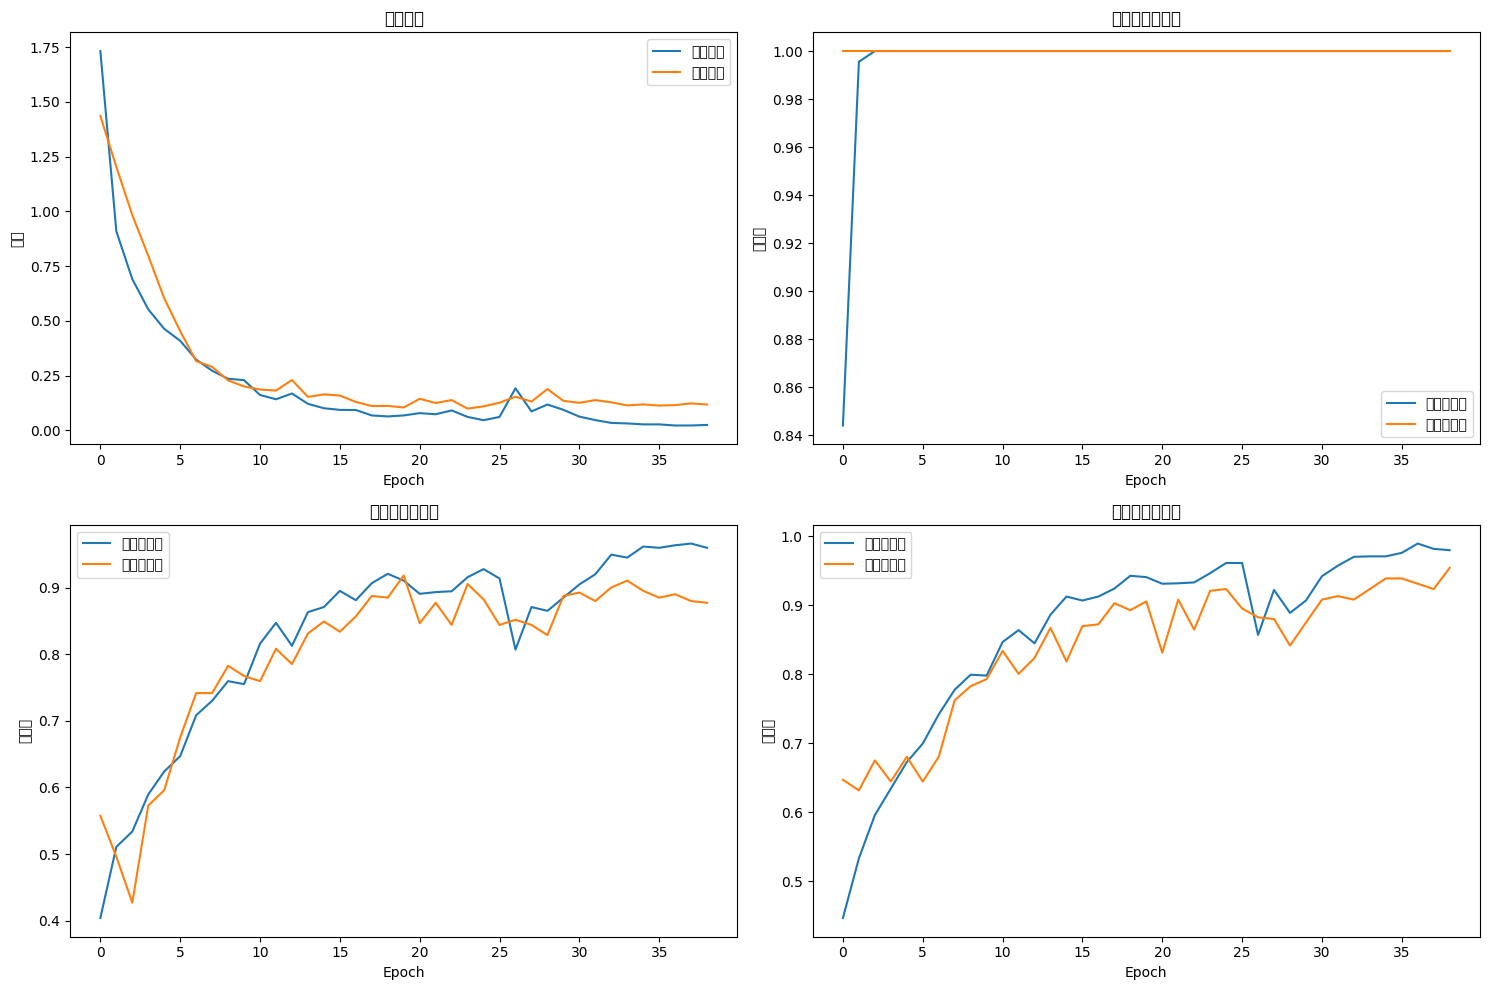

模型已保存
載入測試資訊...
處理測試數據...
已處理 100/1430 個測試檔案
已處理 200/1430 個測試檔案
已處理 300/1430 個測試檔案
已處理 400/1430 個測試檔案
已處理 500/1430 個測試檔案
已處理 600/1430 個測試檔案
已處理 700/1430 個測試檔案
已處理 800/1430 個測試檔案
已處理 900/1430 個測試檔案
已處理 1000/1430 個測試檔案
已處理 1100/1430 個測試檔案
已處理 1200/1430 個測試檔案
已處理 1300/1430 個測試檔案
已處理 1400/1430 個測試檔案
載入模型進行預測...
載入訓練資訊...
處理訓練數據...
已處理 100/1955 個檔案
已處理 200/1955 個檔案
已處理 300/1955 個檔案
已處理 400/1955 個檔案
已處理 500/1955 個檔案
已處理 600/1955 個檔案
已處理 700/1955 個檔案
已處理 800/1955 個檔案
已處理 900/1955 個檔案
已處理 1000/1955 個檔案
已處理 1100/1955 個檔案
已處理 1200/1955 個檔案
已處理 1300/1955 個檔案
已處理 1400/1955 個檔案
已處理 1500/1955 個檔案
已處理 1600/1955 個檔案
已處理 1700/1955 個檔案
已處理 1800/1955 個檔案
已處理 1900/1955 個檔案
數據形狀: X=(1955, 2000, 6), 性別=(1955,), 持拍手=(1955,)
球齡=(1955,), 等級=(1955,)
創建模型...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2000, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2000, 64)  │      1,216 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2000, 64)  │      1,984 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 2000, 64)  │      2,752 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 64)  │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1000, 64)  │          0 │ dropout_10[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1000, 64)  │          0 │ dropout_12[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1000, 64)  │          0 │ dropout_14[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 128) │     24,704 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 128) │     41,088 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 128) │     57,472 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_11[0][0] 

 Total params: 889,289 (3.39 MB)

 Trainable params: 887,625 (3.39 MB)

 Non-trainable params: 1,664 (6.50 KB)

None
開始訓練...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - gender_accuracy: 0.6643 - gender_loss: 0.6360 - hand_accuracy: 0.6222 - hand_loss: 0.7454 - level_accuracy: 0.3629 - level_loss: 0.3629 - loss: 2.6634 - years_accuracy: 0.3940 - years_loss: 0.2781 - val_gender_accuracy: 1.0000 - val_gender_loss: 0.4036 - val_hand_accuracy: 1.0000 - val_hand_loss: 0.4334 - val_level_accuracy: 0.6036 - val_level_loss: 0.1575 - val_loss: 1.3720 - val_years_accuracy: 0.5703 - val_years_loss: 0.1114 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - gender_accuracy: 0.9888 - gender_loss: 0.0586 - hand_accuracy: 0.9961 - hand_loss: 0.0639 - level_accuracy: 0.5421 - level_loss: 0.2086 - loss: 0.9060 - years_accuracy: 0.5157 - years_loss: 0.1831 - val_gender_accuracy: 1.0000 - val_gender_loss: 0.2580 - val_hand_accuracy: 1.0000 - val_hand_loss: 0.2667 - val_level_accuracy: 0.6215 - val_level_loss: 0.1456 - val_loss: 1.0285 - val_years_accuracy: 0.6010 - val_years_l

In [6]:
# 主要執行流程
if __name__ == "__main__":
    print("開始乒乓球揮拍資料分析...")

    # 檢查GPU可用性
    print("GPU可用性:", tf.config.list_physical_devices('GPU'))

    # 訓練模型
    model, history = train_model()

    # 繪製訓練歷史
    plot_training_history(history)

    # 保存模型
    model.save('table_tennis_model.h5')
    print("模型已保存")

    # 生成測試集預測
    predictions = generate_predictions()

    print("分析完成！")